# Influence of Number of Training Epochs

In [2]:
import pickle
A_FILE_NAME = "A_testing_num_epochs_data.pkl"
TEXTWIDTH = 5.78853# inches

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

## Retrieve data

In [ ]:
import wandb
import pandas as pd
import pickle

run_ids = []
with open('A_testing_num_epochs_ids.txt', 'r') as file:
    for line in file:
        run_ids.append(line.strip())


api = wandb.Api()
history_dict = {}
metrics = ["accuracy","eval_loss","train_st2_loss"]
for run_id in run_ids:
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the 'num_train_epochs' value
    num_train_epochs = run.config['num_train_epochs']
    train_size = run.config["training_size"]
    seed = run.config["seed"]
    
    # Fetch the history and extract the 'accuracy' column
    history = run.scan_history(keys=["accuracy","eval_loss","train_st2_loss"])
    metrics = pd.DataFrame([row for row in history]).add_suffix(f'_{seed}')
    
    if train_size not in history_dict:
        history_dict[train_size] = {}
    # If 'num_train_epochs' is not in the dictionary, add it
    if num_train_epochs not in history_dict[train_size]:
        history_dict[train_size][num_train_epochs] = pd.DataFrame()

    history_dict[train_size][num_train_epochs] = pd.concat([history_dict[train_size][num_train_epochs],metrics],axis=1)
    
for num_train_epochs, accuracy in history_dict.items():
    print(f'num_train_epochs: {num_train_epochs}')
    print(accuracy)
history_dict = {k1: {k2: history_dict[k1][k2] for k2 in sorted(history_dict[k1])} for k1 in sorted(history_dict)}

# history_dict = {k: history_dict[k] for k in sorted(history_dict)}
with open(A_FILE_NAME,'wb') as f:
    pickle.dump(history_dict,f)

## Plot data

In [3]:
import pickle
with open(A_FILE_NAME,'rb') as f:
    history_dict = pickle.load(f)

#### Plot median metric at each timestep

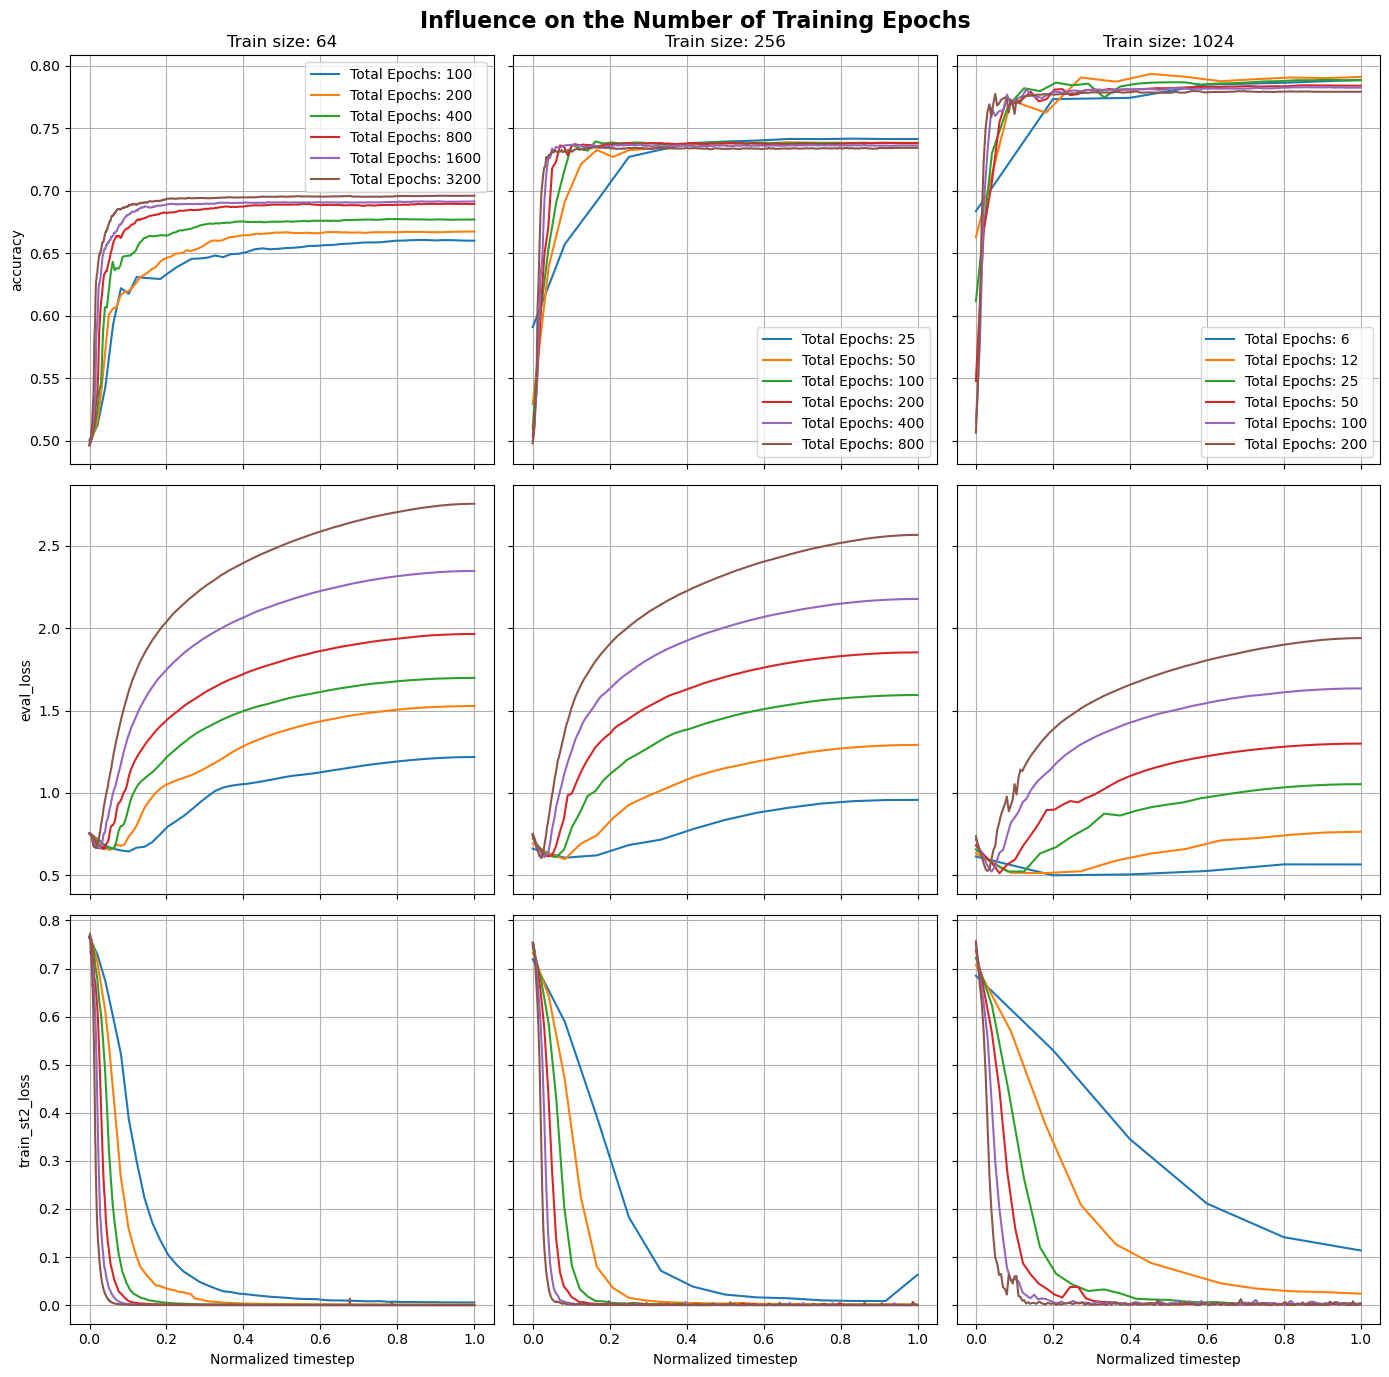

In [10]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(metrics),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, (train_size, sub_dict) in enumerate(history_dict.items()):
    for idx, metric in enumerate(metrics):
        for num_train_epochs, history_df in sub_dict.items():
            metric_columns = history_df.filter(regex=f'{metric}_').copy()
            # Compute the mean, standard deviation, and median
            metric_columns['mean'] = metric_columns.mean(axis=1)
            metric_columns['std'] = metric_columns.std(axis=1)
            metric_columns['median'] = metric_columns.median(axis=1)
        
            # Normalize the index (timesteps) to a range from 0 to 1
            normalized_index = metric_columns.index / metric_columns.index.max()
            # Plot the median on the respective subplot
            line, = axs[idx,idy].plot(
                normalized_index,
                metric_columns['mean'],
                label=f'Total Epochs: {num_train_epochs}'
                )
            
            # color = line.get_color()
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] - metric_columns['std'], color=color, linestyle='--')
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] + metric_columns['std'], color=color, linestyle='--')
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=1)
        if idy == 0:
            axs[idx,idy].set_ylabel(metric)
        if idx == 0:
            axs[idx,idy].set_title(f'Train size: {train_size}')
        if idx == len(history_dict) - 1:
            axs[idx,idy].set_xlabel('Normalized timestep')
            # axs[idx,idy].set_xlabel('Epoch')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()
fig.suptitle('Influence on the Number of Training Epochs', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
# plt.savefig('A_testing_num_epochs_plot_normalized.pdf', format='pdf')
plt.show()

# Influence of the Learning Rate with DO/LR Sweep Data

In [2]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

In [3]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df
df_64 = read_wandb_csv("B_0064_sweeps_400QNLI.csv")
df_256 = read_wandb_csv("B_0256_sweeps_100QNLI.csv")
df_1024 = read_wandb_csv("B_1024_sweeps_25QNLI.csv")

In [4]:
df_all = pd.concat([df_64,df_256,df_1024], axis=0, ignore_index=True)
df_all["ID"]

0       u3272tl6
1       hbm8kny9
2       hosc0890
3       tfngl3qm
4       c0dvm3jw
          ...   
1075    sklqjagg
1076    nqfiex8f
1077    tjyzqfs8
1078    7dlemub3
1079    mxjmxtav
Name: ID, Length: 1080, dtype: object

In [ ]:
from tqdm import tqdm
run_ids = df_all["ID"]

api = wandb.Api()

all_dfs = []
metrics = ["accuracy","eval_loss","train_st2_loss","learning_rate","eval_p_max"]
index_keys = ["_step","epoch"]
all_keys = metrics+index_keys

# Add tqdm to the loop for progress bar
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the history and extract the 'accuracy' column
    history = run.scan_history(keys=all_keys)
    df_run = pd.DataFrame([row for row in history])
    for key, value in run.config.items():
        df_run = df_run.assign(**{key: value})
    
    all_dfs.append(df_run)

df = pd.concat(all_dfs,axis=0,ignore_index=True)
with open("A_2_learning_rate.pkl",'wb') as f:
    pickle.dump(df,f)

100%|██████████| 1080/1080 [22:31<00:00,  1.25s/it]


In [5]:
with open("A_2_learning_rate.pkl",'rb') as f:
    df = pickle.load(f)
df.head()

,accuracy,eval_loss,train_st2_loss,learning_rate,eval_p_max,_step,epoch,seed,beta1,beta2,...,checkpointing_steps,warmup_steps_fraction,resume_from_checkpoint,early_stopping_patience,ignore_mismatched_sizes,early_stopping_min_delta,original_gradient_fraction,per_device_eval_batch_size,gradient_accumulation_steps,per_device_train_batch_size
0,0.466044,0.802154,0.750433,0.000008,0.662995,4,1,3,0.9,0.999,...,None,0.1,None,25,False,0,0,128,1,32
1,0.465495,0.800938,0.810296,0.000008,0.661337,8,3,3,0.9,0.999,...,None,0.1,None,25,False,0,0,128,1,32
2,0.465312,0.798837,0.785536,0.000008,0.658452,12,5,3,0.9,0.999,...,None,0.1,None,25,False,0,0,128,1,32
3,0.465678,0.796001,0.798362,0.000008,0.654397,16,7,3,0.9,0.999,...,None,0.1,None,25,False,0,0,128,1,32
4,0.465495,0.792396,0.767459,0.000008,0.649317,20,9,3,0.9,0.999,...,None,0.1,None,25,False,0,0,128,1,32


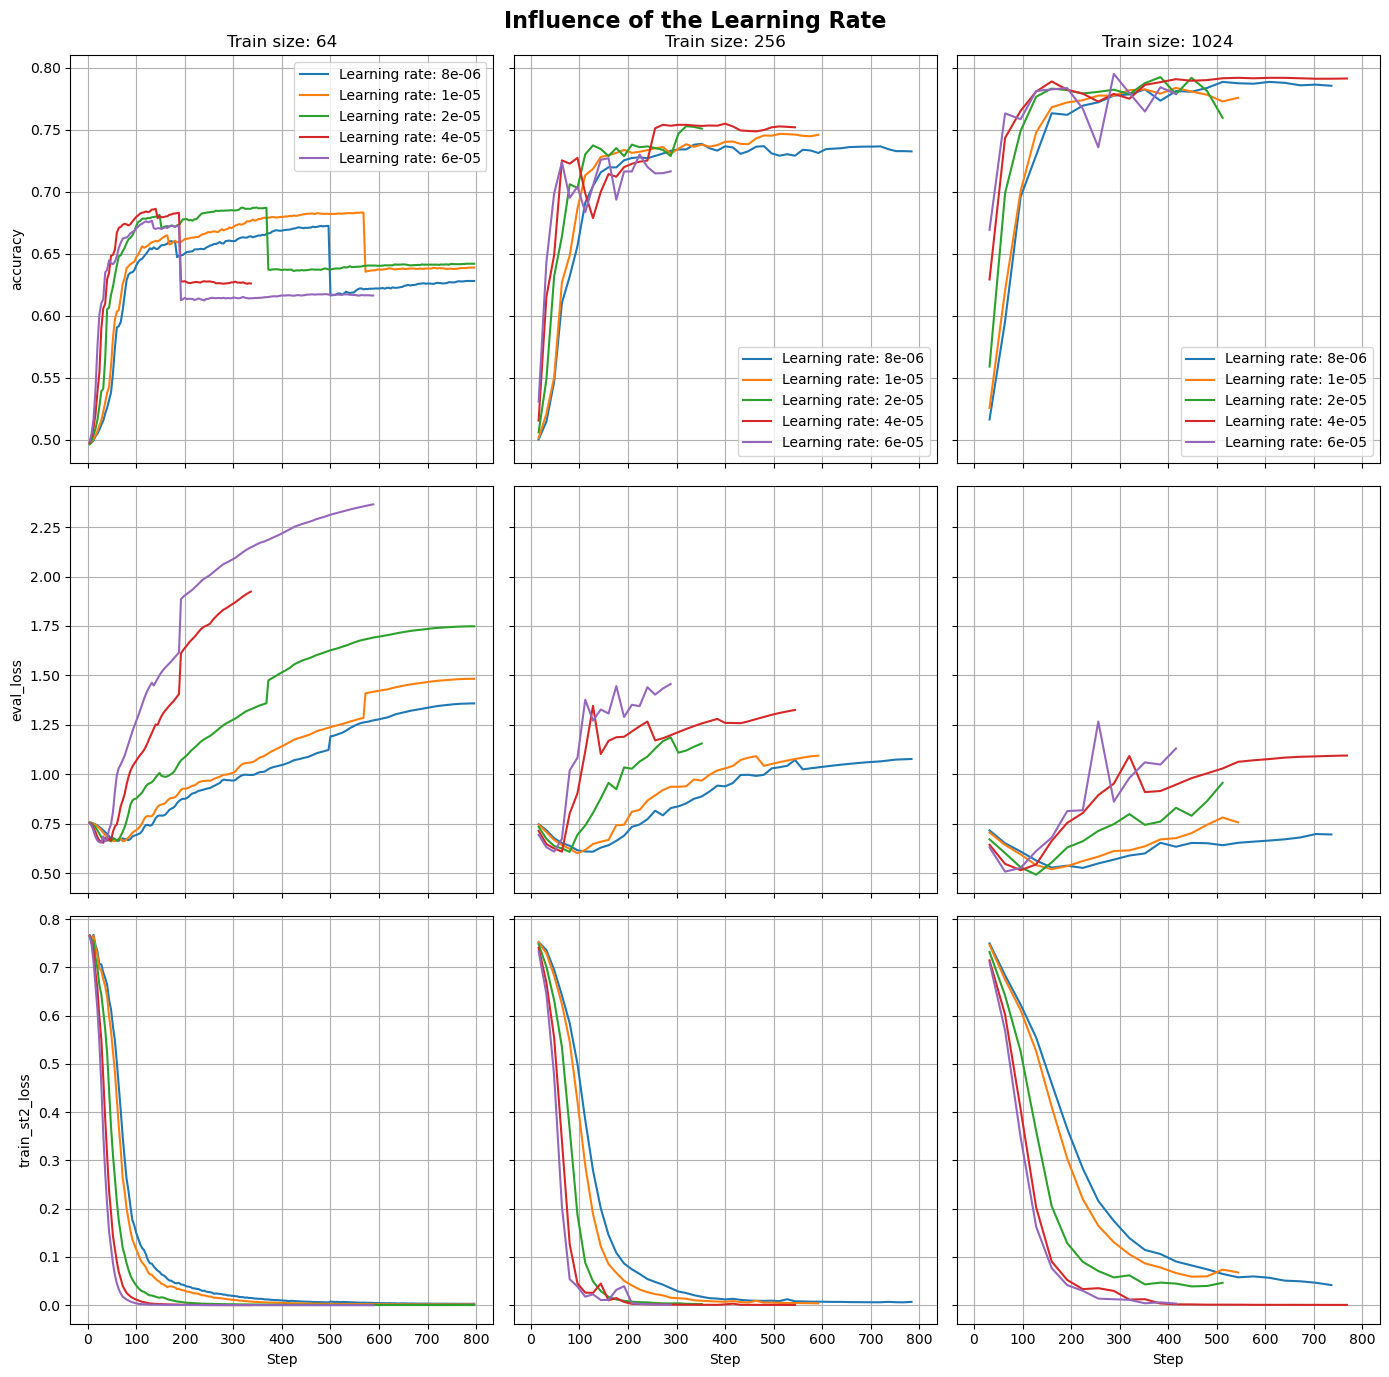

In [15]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(metrics),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
selected_rows = functools.reduce(
    operator.and_,
    [
        df["insert_dropout"] == 0.1,
        df["dataset_seed"] == 1,
        df["mode"] == 'VANILLA'
        # df["Tags"].str.contains('modded')
    ]  
    )

filtered_df = df.loc[selected_rows]

training_sizes = df["training_size"].unique()
for idy, train_size in enumerate(training_sizes):
    for idx, metric in enumerate(metrics):
        grouped_df = filtered_df.loc[df["training_size"]==train_size].groupby(["learning_rate","_step"])
        statistics = grouped_df[metric].agg(['mean', 'median', 'std'])
        # idx = medians.groupby(['mode','training_size']).idxmax()
        # best_combinations = filtered_df.loc[filtered_df.set_index(['mode','training_size', 'insert_dropout', 'learning_rate',]).index.isin(idx)]

        for learning_rate in statistics.index.get_level_values('learning_rate').unique():
            lr_stats = statistics.loc[learning_rate]
            axs[idx,idy].plot(lr_stats.index, lr_stats["mean"], label=f'Learning rate: {learning_rate}')

    
            # color = line.get_color()
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] - metric_columns['std'], color=color, linestyle='--')
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] + metric_columns['std'], color=color, linestyle='--')
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=1)
        if idy == 0:
            axs[idx,idy].set_ylabel(metric)
        if idx == 0:
            axs[idx,idy].set_title(f'Train size: {train_size}')
        if idx == len(training_sizes) - 1:
            axs[idx,idy].set_xlabel('Step')
            # axs[idx,idy].set_xlabel('Epoch')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()
fig.suptitle('Influence of the Learning Rate', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
# plt.savefig('A_testing_num_epochs_plot_normalized.pdf', format='pdf')
plt.show()

# Influence of the Learning Rate with New LR Sweep

In [20]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

In [21]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

id_df = read_wandb_csv("A_2_learning_rate_tests.csv")
id_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,ID,Group,...,test_f1_best_eval_loss,test_f1_best_f1,train_loss,train_p_max,train_p_var,train_st1_loss,train_st1_p_max,train_st2_loss,train_st2_p_max,vector_norms
0,25_S2_ID_35_MOD,finished,-,ricu,"SWP2, modded",2024-01-13T19:32:46.000Z,282,NaN,4gfkpft1,NaN,...,NaN,NaN,NaN,NaN,NaN,20.220779,17.704159,20.523252,17.906464,"{""_type"":""histogram"",""bins"":[0.000050217975513..."
1,25_S2_ID_34_MOD,finished,-,ricu,"SWP2, modded",2024-01-13T19:27:46.000Z,277,NaN,leo79blq,NaN,...,NaN,NaN,NaN,NaN,NaN,15.234844,22.085957,16.203117,21.769491,"{""_type"":""histogram"",""bins"":[0.000067856424720..."
2,25_S2_ID_33_MOD,finished,-,ricu,"SWP2, modded",2024-01-13T19:22:43.000Z,280,NaN,zphode38,NaN,...,NaN,NaN,NaN,NaN,NaN,13.519812,23.753351,15.262937,23.064470,"{""_type"":""histogram"",""values"":[257,206,145,101..."
3,25_S2_ID_32_MOD,finished,-,ricu,"SWP2, modded",2024-01-13T19:17:41.000Z,279,NaN,e8cf1i0a,NaN,...,NaN,NaN,NaN,NaN,NaN,20.801037,17.258829,20.950600,17.704020,"{""values"":[83,90,100,80,64,94,74,63,52,42,45,3..."
4,25_S2_ID_31_MOD,finished,-,ricu,"SWP2, modded",2024-01-13T19:12:43.000Z,277,NaN,7grysqco,NaN,...,NaN,NaN,NaN,NaN,NaN,15.789784,21.432907,16.636168,21.161684,"{""_type"":""histogram"",""bins"":[0.000026584177248..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,25_S3_ID_02_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-12T23:28:59.000Z,980,NaN,q69622xr,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000109,0.999891,NaN
212,25_S0_ID_01_MOD,finished,-,ricu,"SWP0, modded",2024-01-12T23:16:07.000Z,1180,NaN,hconuqvb,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000162,0.999838,0.000219,0.999781,"{""_type"":""histogram"",""bins"":[5.401670932769775..."
213,25_S3_ID_01_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-12T23:12:44.000Z,951,NaN,8o876b0k,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000176,0.999824,NaN
214,25_S3_ID_00_VAN,finished,-,ricu,"SWP3, vanilla",2024-01-12T22:56:32.000Z,949,NaN,pbht198p,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000248,0.999752,NaN


In [50]:
from tqdm import tqdm
run_ids = id_df["ID"]

api = wandb.Api()

all_dfs = []
metrics_train = ["train_st2_loss"]
metrics_eval = ["accuracy","eval_loss","eval_p_max"]
metrics_lr = ["learning_rate"]
index_keys = ["_step","epoch"]

# Add tqdm to the loop for progress bar
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the history
    history_train = run.scan_history(keys=metrics_train+index_keys)
    df_run =  pd.DataFrame([row for row in history_train])
    
    history_eval = run.scan_history(keys=metrics_eval+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_eval]), on=['_step', 'epoch'], how='outer')
    
    history_lr = run.scan_history(keys=metrics_lr+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_lr]), on=['_step', 'epoch'], how='outer')
    df_run = df_run.sort_values(by="_step", ascending=True,ignore_index=True)
    last_step_diff = df_run["_step"].iloc[-1] - df_run["_step"].iloc[-2]
    first_step_diff = df_run["_step"].iloc[1] - df_run["_step"].iloc[0]
    if last_step_diff != first_step_diff:
        df_run.at[df_run.index[-1], 'train_st2_loss'] = df_run['train_st2_loss'].iloc[-1] / last_step_diff
    df_run["learning_rate"] = df_run["learning_rate"].fillna(0)

    for key, value in run.config.items():
        df_run = df_run.assign(**{key: value})
    
    all_dfs.append(df_run)

df = pd.concat(all_dfs,axis=0,ignore_index=True)
with open("A_2_learning_rate_new2.pkl",'wb') as f:
    pickle.dump(df,f)

100%|██████████| 216/216 [08:13<00:00,  2.29s/it]


In [59]:
with open("A_2_learning_rate_new2.pkl",'rb') as f:
    df = pickle.load(f)
df.head()

,train_st2_loss,_step,epoch,accuracy,eval_loss,eval_p_max,learning_rate,seed,beta1,beta2,...,num_warmup_steps,lr_scheduler_type,pad_to_max_length,model_name_or_path,warmup_steps_fraction,early_stopping_patience,ignore_mismatched_sizes,early_stopping_min_delta,per_device_eval_batch_size,per_device_train_batch_size
0,NaN,0,-1,0.453613,0.806656,0.662279,0.000001,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,800,False,0,128,32
1,0.807563,64,1,0.465820,0.785914,0.647249,0.000001,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,800,False,0,128,32
2,0.771405,128,3,0.485352,0.745074,0.608526,0.000001,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,800,False,0,128,32
3,0.732386,192,5,0.495117,0.716926,0.576596,0.000001,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,800,False,0,128,32
4,0.707262,256,7,0.497559,0.699109,0.553873,0.000001,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,800,False,0,128,32


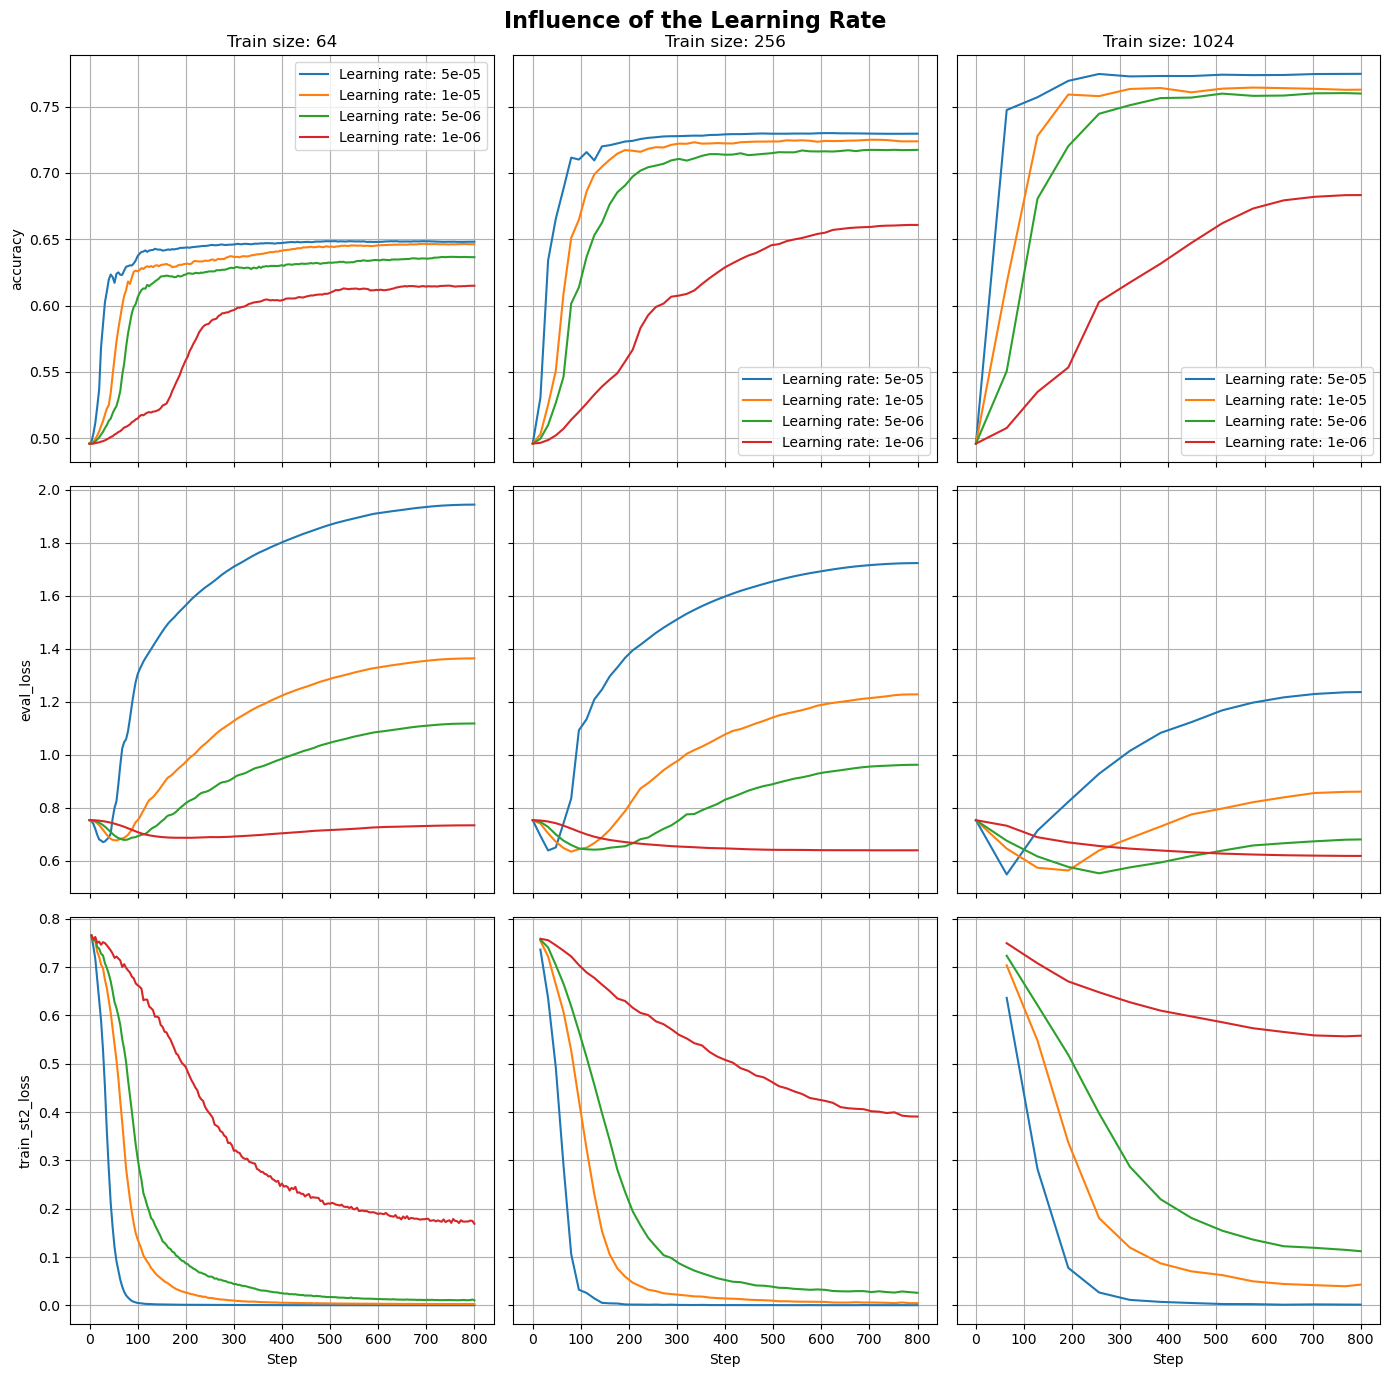

In [72]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(metrics),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})

training_sizes = sorted(df["training_size"].unique())
selected_rows = functools.reduce(
    operator.and_,
    [
        df["mode"] == 'FUMBRELLA'
        # df["Tags"].str.contains('modded')
    ]  
    )
filtered_df = df.loc[selected_rows]
for idy, train_size in enumerate(training_sizes):
    for idx, metric in enumerate(metrics):
        grouped_df = filtered_df.loc[df["training_size"]==train_size].groupby(["learning_rate","_step"])
        statistics = grouped_df[metric].agg(['mean', 'median', 'std'])
        statistics = statistics.sort_index(level='learning_rate', ascending=False)

        for learning_rate in statistics.index.get_level_values('learning_rate').unique():
            lr_stats = statistics.loc[learning_rate]
            axs[idx,idy].plot(lr_stats.index, lr_stats["mean"], label=f'Learning rate: {learning_rate}')

        if idy == 0:
            axs[idx,idy].set_ylabel(metric)
        if idx == 0:
            axs[idx,idy].set_title(f'Train size: {train_size}')
        if idx == len(training_sizes) - 1:
            axs[idx,idy].set_xlabel('Step')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()


fig.suptitle('Influence of the Learning Rate', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_2_testing_learning_rate.pdf', format='pdf')
plt.show()

In [29]:
filtered_df["epoch"].min()

1